In [34]:
import os
import sys
import typing as t
from PIL import Image

import numpy as np
np.seterr(divide='ignore', invalid='ignore')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import skimage.color

# add src to path
sys.path.append('../..')
from utils.db_helper import get_image_data

In [54]:
SOURCE_DIR_STYLE = R"F:\master-thesis-databases\classification_db\fake"
SOURCE_DIR_FFHQ = R"F:\master-thesis-databases\classification_db\real"
base_save_path = os.path.join("..", "..", "..", "exp", "Histograms")


In [37]:
def all_colorspaces_from_rgb(np_rgb_img: np.ndarray)-> np.ndarray:
    """R,G,B,H,S,V,Y,Cb,Cr"""
    if np_rgb_img.shape[2] < 3 or len(np_rgb_img.shape) != 3:
        raise ValueError("Bad shape of input image")
    np_img_hsv = skimage.color.rgb2hsv(np_rgb_img)
    np_img_ycbcr = skimage.color.rgb2ycbcr(np_rgb_img) / 255
    # (x,y,9) shape insted of (x,y,3)
    new_shape = list(np_rgb_img.shape[:2])+[9]
    np_img_all_colors = np.empty(new_shape)
    np_img_all_colors[:,:,:3] = np_rgb_img
    np_img_all_colors[:,:,3:6] = np_img_hsv
    np_img_all_colors[:,:,6:] = np_img_ycbcr
    return np_img_all_colors

In [38]:
def draw_color_components_histogram(src_path: str):
    dataset_gen = get_image_data(src_path, type='float', grayscale=False, max_number_of_images=2000)
    bins=256
    hist_range = (0,1)
    number_of_images = 0
    number_of_colorspaces = 9
    np_avg_hist = np.zeros((bins,number_of_colorspaces), dtype=np.float64)
    for np_img in dataset_gen:
        np_all_colorspaces = all_colorspaces_from_rgb(np_img)
        for colorspace in range(number_of_colorspaces):
            hist, _ = np.histogram(np_all_colorspaces[:,:,colorspace],                                               density=True, bins=bins, range=hist_range)
            np_avg_hist[:,colorspace] += hist
        number_of_images += 1
        if np_avg_hist.max() > 0.95*np.finfo(np_avg_hist.dtype).max:
            raise ValueError("Dataset to large")
            break
        # elif number_of_images == max_number_of_images:
        #     print("Finish calcluating avg histogram")
        #     break
    return np_avg_hist / number_of_images, range(0, 1, 1/bins)

In [39]:
x, bins = draw_color_components_histogram(SOURCE_DIR_FFHQ)
y, bins = draw_color_components_histogram(SOURCE_DIR_STYLE)

len: 2000
len: 2000


In [57]:
color_componenets = ("R", "G", "B", "H", "S", "V", "Y", "Cb", "Cr")
save_path = os.path.join(base_save_path, "Color_components_avg_histograms_sharey.png")


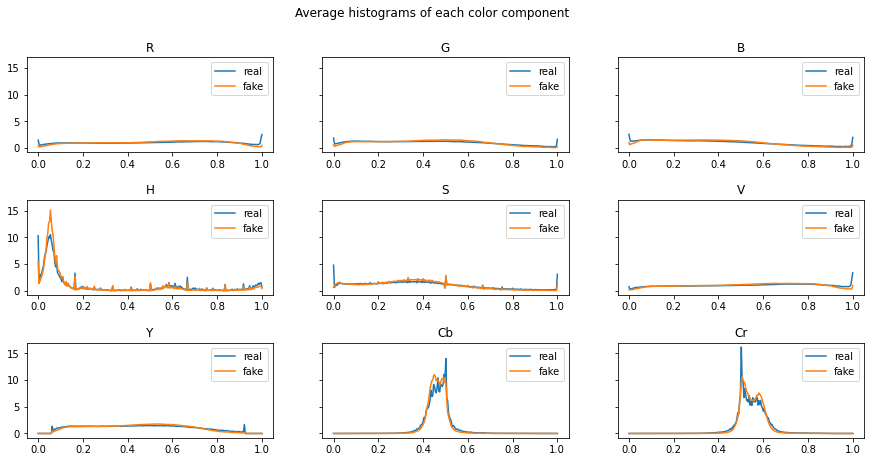

In [58]:
fig, axs = plt.subplots(ncols=3, nrows=3, sharey=True, figsize=(15,7))
fig.suptitle("Average histograms of each color component")
plt.subplots_adjust(hspace=0.5)
for i in range(9):
    axs[int(i/3),i%3].plot(np.linspace(0,1,num=256), x[:,i])
    axs[int(i/3),i%3].plot(np.linspace(0,1,num=256), y[:,i])
    axs[int(i/3),i%3].legend(['real', 'fake'])
    axs[int(i/3),i%3].set_title(color_componenets[i])
plt.savefig(save_path)
    

